In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
ticker = yf.Ticker("AMZN")
stock_data = ticker.history(period="1d", interval="1m")
stock_data = stock_data[['Close']]
stock_data.reset_index(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close']])

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.2118 - val_loss: 0.0099
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0271 - val_loss: 0.0083
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0146 - val_loss: 0.0175
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - val_loss: 0.0084
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0109 - val_loss: 0.0075
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0097 - val_loss: 0.0074
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085 - val_loss: 0.0058
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0096 - val_loss: 0.0047
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0083 - val_loss: 0.0046
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 13/50


In [6]:
# Prepare data for prediction
last_sequence = scaled_data[-sequence_length:]
last_sequence = np.reshape(last_sequence, (1, sequence_length, 1))

# Predict next 10 minutes
predictions = []
for _ in range(10):
    next_price = model.predict(last_sequence)
    predictions.append(next_price[0][0])
    last_sequence = np.concatenate((last_sequence[:, 1:, :], np.reshape(next_price, (1, 1, 1))), axis=1)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


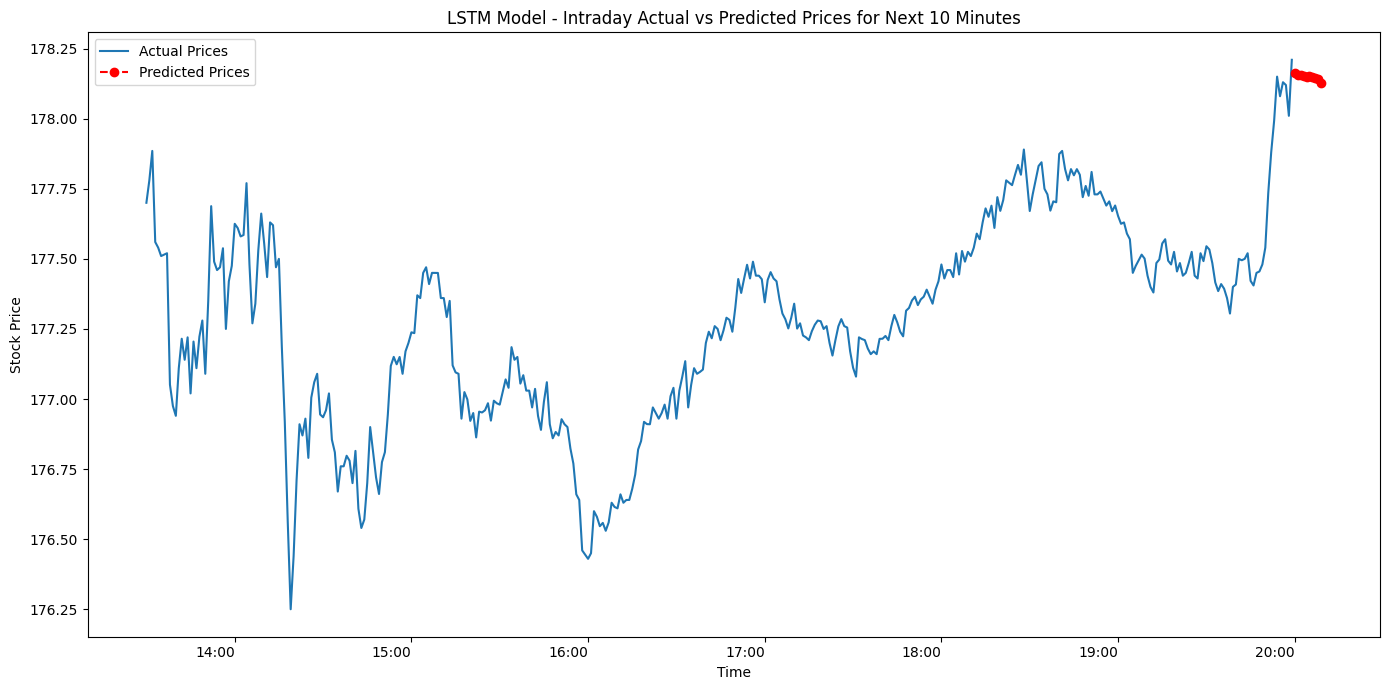

In [9]:
future_dates = pd.date_range(start=stock_data['Datetime'].iloc[-1] + pd.Timedelta(minutes=1), periods=10, freq='T')

# Create DataFrame for predictions
predictions_df = pd.DataFrame({
    'Datetime': future_dates,
    'Predicted': predictions
})

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Datetime'], stock_data['Close'], label='Actual Prices')
plt.plot(predictions_df['Datetime'], predictions_df['Predicted'], color='red', marker='o', linestyle='--', label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('LSTM Model - Intraday Actual vs Predicted Prices for Next 10 Minutes')
plt.legend()

# Format x-axis to show hours only
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:00'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotation

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()